# Notebook Objectives
- generate synthetic time-series [ using [TimeSynth](https://github.com/TimeSynth/TimeSynth) ]
- visualize data
- pre-process [ split train/test, and normalize ]
- build model 
- train model
- evaluate model


In [1]:
!pip install git+https://github.com/TimeSynth/TimeSynth.git

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-61gnrdv0
  Created wheel for timesynth: filename=timesynth-0.2.4-py3-none-any.whl size=15429 sha256=682ea029df6b52b1518bee1ec9a1244031e892ec619ae9c73f21b5d60f5e994e
  Stored in directory: /tmp/pip-ephem-wheel-cache-o5seg6lh/wheels/1d/04/7b/809ba241ad092fb99ab6017a100960a3183808268760e3c3b6
Successfully built timesynth


In [2]:
import numpy as np
import timesynth as ts
import matplotlib.pylab as plt

# Generate Synthetic TimeSeries

In [3]:
nSamples = 100000
samplesPerSensorInput = 100

In [4]:
def generate_time_series ( nSamples, signalType ):    
    ''' 
        generate timeseries object, for additional signal types see 
            https://github.com/TimeSynth/TimeSynth
    '''
    
    if signalType == 1: 
        # sinusoidal signal with gaussian noise
        timeseries = ts.TimeSeries( signal_generator = ts.signals.Sinusoidal(frequency=.05),
                                    noise_generator = ts.noise.GaussianNoise(std=0.25))    
    elif signalType == 2: 
        # [narma] non-linear autoregressive moving average generator
        timeseries = ts.TimeSeries( signal_generator = ts.signals.NARMA(order=10) )
        
    elif signalType == 3: 
        # autoregressive process - second order
        timeseries = ts.TimeSeries( signal_generator = ts.signals.AutoRegressive(ar_param=[1.5, -0.75]))
        
    # generate samples
    samples, _, _ = timeseries.sample( ts.TimeSampler(stop_time = nSamples).sample_regular_time(num_points=nSamples) )
    
    # add a padding dimension [ needed for upstream processing ]
    samples = np.expand_dims( samples, axis=1)
    
    return samples

In [5]:
S1 = generate_time_series( nSamples, signalType = 1 )
S2 = generate_time_series( nSamples, signalType = 2 )
S3 = generate_time_series( nSamples, signalType = 3 )

/opt/conda/envs/rapids/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# Visualize Data at Multiple Scales

In [6]:
def plot_data ( data ):    
    plt.figure(figsize = (10,15));     
    plt.subplot(4,1,1); plt.plot(data); plt.title('all data')
    plt.subplot(4,1,2); plt.plot(data[0:int(data.shape[0]//10.0)]); plt.title('first 10%')
    plt.subplot(4,1,3); plt.plot(data[0:int(data.shape[0]//100.0)]); plt.title('first 1%')
    plt.subplot(4,1,4); plt.plot(data[0:int(data.shape[0]//1000.0)], '-x'); plt.title('first .1%')    

(None, None, None)

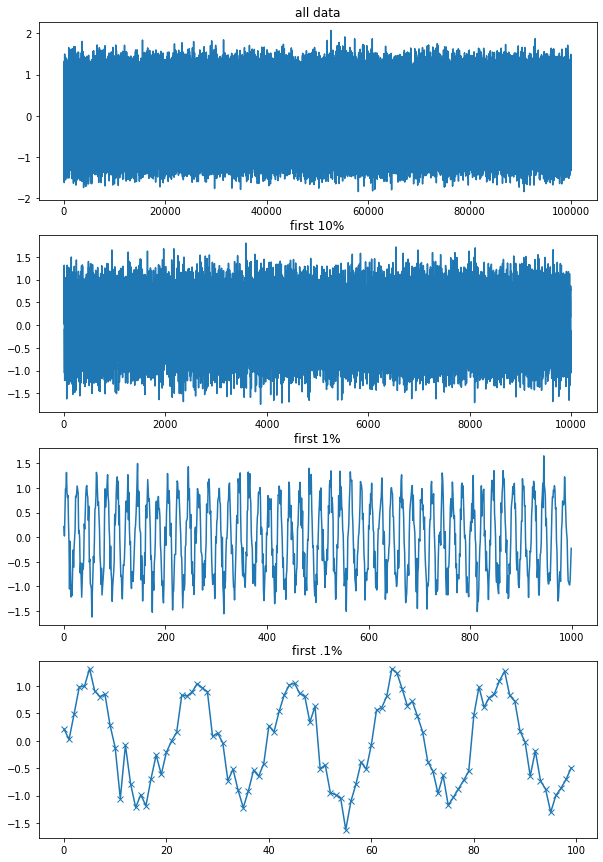

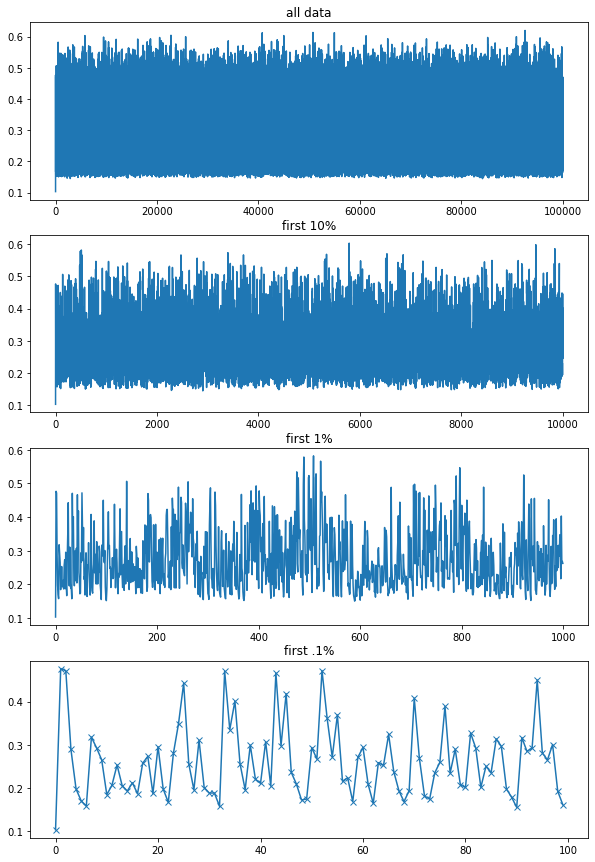

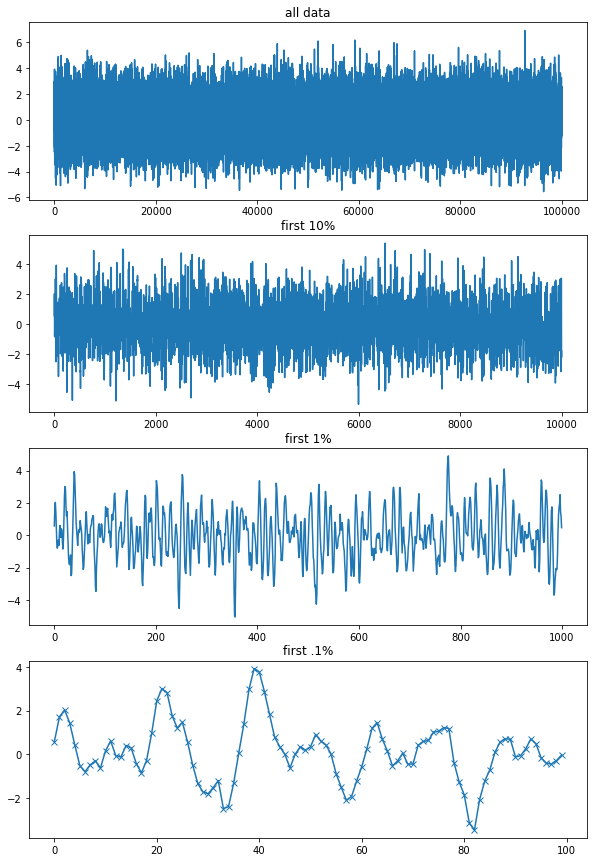

In [7]:
plot_data(S1), plot_data(S2), plot_data(S3)

# Data Prep -- split and normalize

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
def split_and_rescale ( X ):
    X_train, X_test = train_test_split( X, test_size = .25, shuffle = False )
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform( X_train )
    X_test_scaled = scaler.transform( X_test )
    return X_train_scaled, X_test_scaled

In [10]:
S1_train_scaled, S3_test_scaled = split_and_rescale(S1)
S2_train_scaled, S2_test_scaled = split_and_rescale(S2)
S3_train_scaled, S3_test_scaled = split_and_rescale(S3)

# Generate Sliding Windows and Shuffle

In [11]:
def reshape_into_sliding_windows ( X, windowSize, advanceSamples = 1 ):
    # determine number of sliding windows that fit within dataset
    nWindows = int( np.floor( (X.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    
    # pre-allocate matrix which holds sliding windows
    outputMatrix = np.zeros((nWindows, windowSize))
    
    # populate each sliding window
    for iWindow in range(nWindows):
        startIndex = iWindow * advanceSamples
        endIndex = startIndex + windowSize
        
        outputMatrix[iWindow, :] = X[ startIndex:endIndex, 0]
    
    return outputMatrix

In [12]:
S1_train_scaled_windowed = reshape_into_sliding_windows( S1_train_scaled, samplesPerSensorInput)
S2_train_scaled_windowed = reshape_into_sliding_windows( S2_train_scaled, samplesPerSensorInput)
S3_train_scaled_windowed = reshape_into_sliding_windows( S3_train_scaled, samplesPerSensorInput)

In [13]:
trainingData = np.hstack( (S1_train_scaled_windowed, S2_train_scaled_windowed, S3_train_scaled_windowed) )

In [14]:
trainingData.shape

(74900, 300)

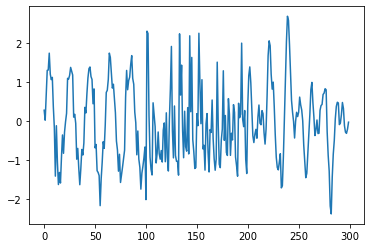

In [15]:
plt.plot(trainingData[0,:], '-')

# Model Building

- be careful to move data to the GPU during training and back to the CPU for visualization
- we need to make sure the data is in np.float32 format to matches the dtype of the model weights
- don't forget to shuffle the data during training 

In [16]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

# Define DataLoaders

In [17]:
trainBatchSize = 16

dataLoaderTrain = DataLoader( trainingData.astype('float32'), 
                              batch_size = trainBatchSize, 
                              shuffle = True )

dataLoaderTest = DataLoader( trainingData.astype('float32'), 
                             batch_size = 1, 
                             shuffle = False )

# Declare Model

In [18]:
trainingData.shape

(74900, 300)

In [19]:
inputDimensionality = trainingData.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

In [20]:
from nnViz_pytorch import *

In [21]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

11
117000


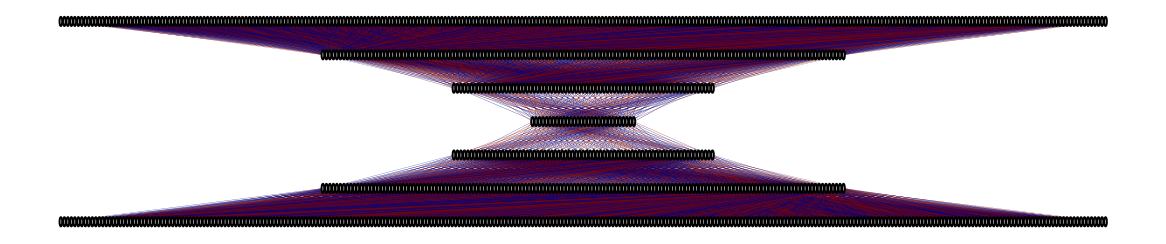

elapsed time: 2.852778434753418


In [22]:
startTime = time.time()

plt.figure(figsize=(20,4)); ax = plt.gca()

visualize_model(model, ax)

plt.axis('tight'); plt.axis('off'); plt.show()

print('elapsed time: {}'.format(time.time()-startTime))

# Sensor Mask
Lets build a numeric mask to indicate which sensor we hope to target.

This mask vector will be combined ( multiplied ) with the regular mean-squared-loss and effectively zero out non targeted segments.

In [23]:
sensorMask = np.zeros( (trainingData.shape[1],  ) ).astype('float32')

Just to demonstrate how this works, let's focus/specialize the model to only reconstruct the last sensor's data, i.e., input segment between 200-300. Note that when applying this to another dataset, you should be careful to correctly set these bounds for each specialized model.

In [24]:
targetSensorStartIndex = 200
targetSensorEndIndex = 300
sensorMask[targetSensorStartIndex:targetSensorEndIndex] = 1 

In [25]:
sensorMask

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Determine Target Device for Training

In [26]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

# Training Loop

In [27]:
def train_model ( model, sensorMask, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            # note that we are not yet doing the default reduction [ average ] to enable the unrolled loss to be masked
            loss = nn.MSELoss( reduce=False )( iInputBatch, predictions )
            
            # replicate the mask to match the batch size
            # note that we can get partial batches at the end of the dataset, hence we base the replication on the loss shape 
            lossMask = torch.from_numpy( sensorMask ).repeat( loss.shape[0], 1 ).to( targetDevice )
            
            # apply mask
            maskedLoss = torch.mul( loss, lossMask )
            
            # reduce loss to a scaler
            lossAvg = maskedLoss.mean()                         
            
            # compute gradients by propagating the masked and reduced error backward through the model/graph
            lossAvg.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
            cumulativeLoss += lossAvg
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

### Run Training Loop

In [28]:
startTime = time.time()

model, lossHistory = train_model( model, sensorMask, dataLoaderTrain, targetDevice, nEpochs = 5 )

print('elapsed time : {} '.format(time.time() - startTime))

/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch 0 of 5 -- avg batch loss: 1366.5660400390625
epoch 1 of 5 -- avg batch loss: 1293.133056640625
epoch 2 of 5 -- avg batch loss: 1229.179931640625
epoch 3 of 5 -- avg batch loss: 1081.107177734375
epoch 4 of 5 -- avg batch loss: 1010.068359375
elapsed time : 110.96873903274536 


### Visualize Progression of Learning

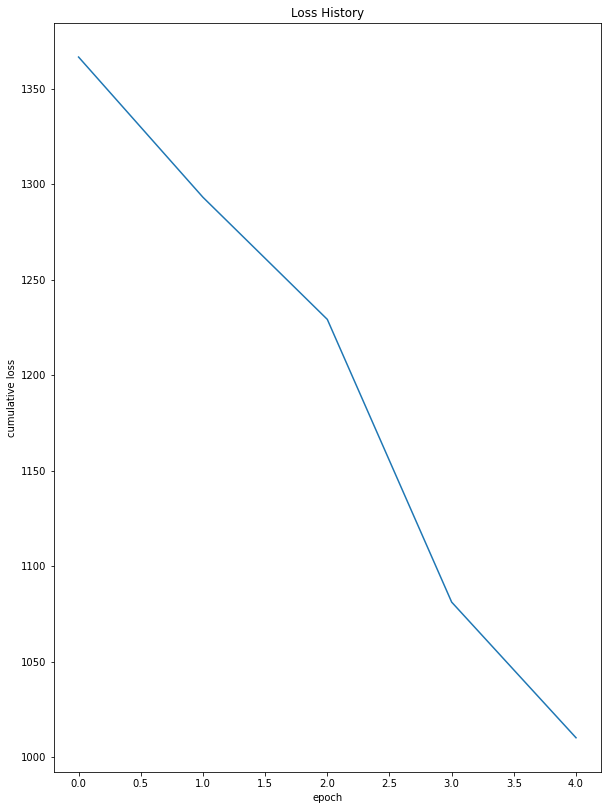

In [29]:
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

# Evaluate Model Performance

Simple demo using a single sample 

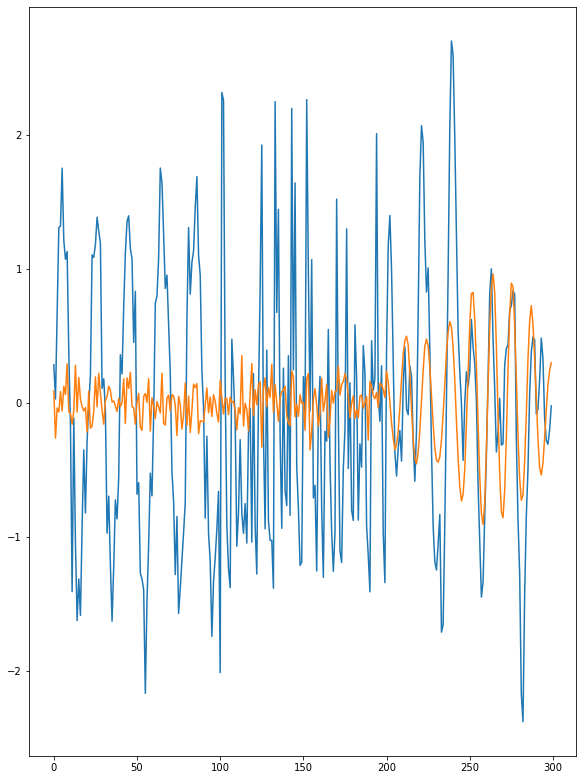

In [30]:
sample = iter(dataLoaderTest).next()[0] # get first element from sample batch        
reconstruction = model.forward(sample.to(targetDevice))
plt.plot(sample.numpy())
plt.plot(reconstruction.data.cpu().numpy())

We can also build an evaluation function that displays results and allows for multiple inferences

In [31]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 3):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )

        plt.figure(figsize=(9,5))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.legend( ['reconstruction error'] )


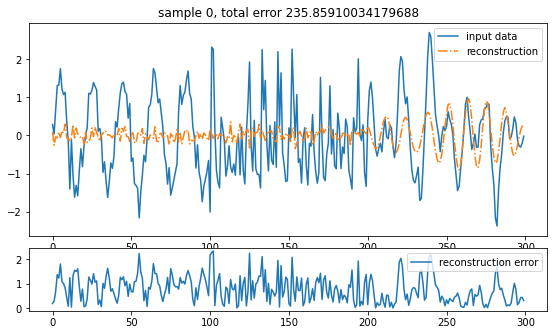

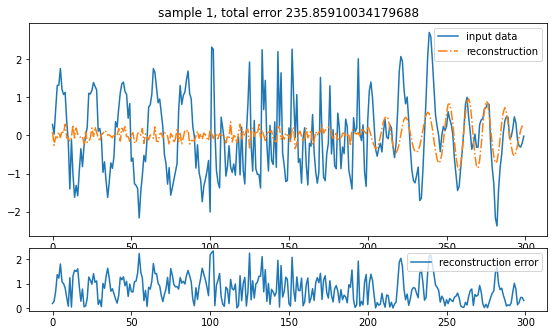

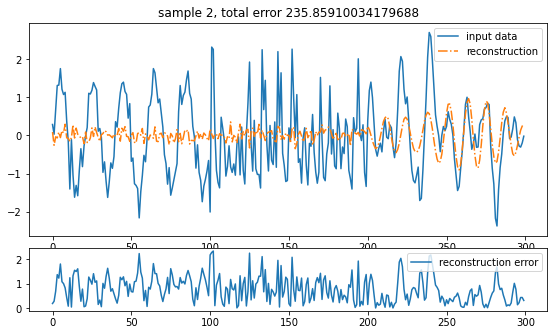

In [32]:
evaluate_model( model, dataLoaderTest, targetDeviceGPU)

# TODO: Inject Synthetic Anomalies
- morph 
- replace
- swap

# Advanced Architecture Construction

Note we can also build separate encoder and decoder modules, and combine them together into a final model. This is useful if we want to extract bottleneck activations